In [46]:
# Import necessary libraries
import keras
import sklearn
import numpy as np
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plot
from keras.optimizers import SGD
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import datasets,models,layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Layer, Add

In [47]:
# Loading cifar10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Checking # of training and testing images
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [48]:
# Normalizing image data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [49]:
# Rebuild labels using one hot encoder
encoder = OneHotEncoder()
encoder.fit(y_train)
Y_train = encoder.transform(y_train).toarray()
Y_test = encoder.transform(y_test).toarray()
print('Before one hot encoding, the categories are:')
print(y_train)
print('After one hot encoding, the categories are:')
print(Y_train)

Before one hot encoding, the categories are:
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
After one hot encoding, the categories are:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [50]:
# Applying data augmentation on images
augmen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True,
                            horizontal_flip=True,
                            width_shift_range=[0.04, 0.1, 0.4],
                            height_shift_range=[0.04, 0.1, 0.4],
                            rotation_range=25,
                            zoom_range=[1.0, 1.3])
augmen.fit(x_train)

In [51]:
# ResNet Block Setting Up
# Code reference: https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/resnet.py
# Paper reference: https://arxiv.org/pdf/1512.03385.pdf
class ResnetBasicBlock(Model):
    
    def __init__(self, channels: int, down_sample=False):
    
        kernel_size=(2, 2)
        # channels: same as number of convolution kernels
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        if down_sample:
            self.__strides = [2, 1]
        else:
            self.__strides = [1, 1]

        # We are using glorot_uniform here as initializer, but in the
        # reference, the author used 'he_normal', which is suggested by them.
        initializer = 'glorot_uniform'
        
        # Initialization of the first layer
        self.conv_1 = Conv2D(self.__channels,
                             strides=self.__strides[0],
                             kernel_size=kernel_size, 
                             padding="same", 
                             kernel_initializer=initializer)
        self.bn_1 = BatchNormalization()
        
        # Initialization of the second layer
        self.conv_2 = Conv2D(self.__channels,
                             strides=self.__strides[1],
                             kernel_size=kernel_size,
                             padding="same",
                             kernel_initializer=initializer)
        self.bn_2 = BatchNormalization()
        
        self.merge = Add()
        
        # If there is a skipping, using value of strides to be 2. 
        if self.__down_sample:
            self.res_conv = Conv2D(self.__channels,strides=2,
                                   kernel_size=(1, 1),
                                   kernel_initializer=initializer,
                                   padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        # We follow the chain:conv -> BN -> ReLu -> conv -> BN
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        # If there is down sample
        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # If there is no down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


In [52]:
# Here, we create the ResNet18 model. 
# Code Reference: https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/resnet.py
# Paper Reference: https://arxiv.org/pdf/1512.03385.pdf
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
  
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", 
                             kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()

        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_11 = ResnetBasicBlock(64)
        self.res_12 = ResnetBasicBlock(64)

        self.res_21 = ResnetBasicBlock(128, down_sample=True)
        self.res_22 = ResnetBasicBlock(128)

        self.res_31 = ResnetBasicBlock(256, down_sample=True)
        self.res_32 = ResnetBasicBlock(256)

        self.res_41 = ResnetBasicBlock(512, down_sample=True)
        self.res_42 = ResnetBasicBlock(512)

        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_11, self.res_12, self.res_21, self.res_22, self.res_31, self.res_32, self.res_41, self.res_42]:
            out = res_block(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [56]:
input_shape = (None, 32, 32, 3)
num_classes = 10
model = ResNet18(num_classes)
model.build(input_shape=input_shape)
optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=1e-04)
# model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [57]:
# Training the ResNet Model
epochs = 10
# epochs = 50
step = len(x_train) / 256
history = model.fit(augmen.flow(x_train,Y_train,batch_size = 256), steps_per_epoch=step, batch_size = 256, epochs=epochs,
                    validation_data=(x_test, Y_test))

Epoch 1/10
195/195 [==============================] - 39s 184ms/step - loss: 2.5916 - accuracy: 0.2290 - val_loss: 2.0611 - val_accuracy: 0.2307
Epoch 2/10
195/195 [==============================] - 36s 183ms/step - loss: 1.8674 - accuracy: 0.3165 - val_loss: 2.3794 - val_accuracy: 0.1666
Epoch 3/10
195/195 [==============================] - 38s 196ms/step - loss: 1.7277 - accuracy: 0.3628 - val_loss: 2.9075 - val_accuracy: 0.1520
Epoch 4/10
195/195 [==============================] - 36s 183ms/step - loss: 1.6383 - accuracy: 0.3961 - val_loss: 2.9980 - val_accuracy: 0.1159
Epoch 5/10
195/195 [==============================] - 35s 180ms/step - loss: 1.5642 - accuracy: 0.4238 - val_loss: 3.0888 - val_accuracy: 0.1311
Epoch 6/10
195/195 [==============================] - 37s 187ms/step - loss: 1.5052 - accuracy: 0.4467 - val_loss: 3.2255 - val_accuracy: 0.1178
Epoch 7/10
195/195 [==============================] - 36s 185ms/step - loss: 1.4561 - accuracy: 0.4693 - val_loss: 3.2692 - val_ac

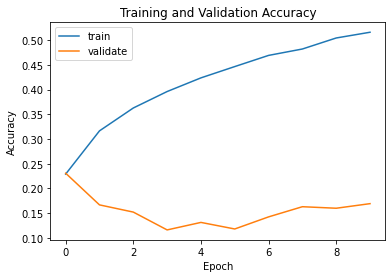

In [58]:
# Plotting model accuracy
plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('Training and Validation Accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend(['train', 'validate'])

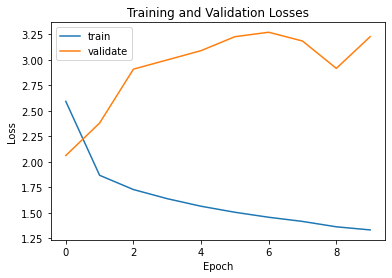

In [59]:
# Plotting model loss
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Training and Validation Losses')
plot.xlabel('Epoch')
plot.ylabel('Loss')
plot.legend(['train', 'validate'])